# Analiza wariantów

In [7]:
import os                               # moduł OS języka Python
user_name = os.environ.get('USER')      # pobieramy zmienną środowiskową USER
bucket = f"gs://edugen-lab-{user_name}" # konstruujemy sciezke dostepowa do pliku
print(bucket)

gs://edugen-lab-tgambin


In [8]:
# sprawdzenie czy dane są dostępne
! gsutil ls -r $bucket


gs://edugen-lab-tgambin/bam/:
gs://edugen-lab-tgambin/bam/
gs://edugen-lab-tgambin/bam/mother10.bam
gs://edugen-lab-tgambin/bam/mother10.bam.bai
gs://edugen-lab-tgambin/bam/mother10.bam.sbi

gs://edugen-lab-tgambin/fastq/:
gs://edugen-lab-tgambin/fastq/
gs://edugen-lab-tgambin/fastq/father.fastq
gs://edugen-lab-tgambin/fastq/mother.fastq
gs://edugen-lab-tgambin/fastq/son.fastq

gs://edugen-lab-tgambin/fastq_backup/:
gs://edugen-lab-tgambin/fastq_backup/father.fastq
gs://edugen-lab-tgambin/fastq_backup/mother.fastq
gs://edugen-lab-tgambin/fastq_backup/son.fastq

gs://edugen-lab-tgambin/vcf/:
gs://edugen-lab-tgambin/vcf/
gs://edugen-lab-tgambin/vcf/mother10.vcf
gs://edugen-lab-tgambin/vcf/mother_anno.vcf
gs://edugen-lab-tgambin/vcf/mother_dec.vcf


## Przygotowanie sesji Spark


In [9]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.config('spark.driver.memory','1g') \
.config('spark.executor.memory', '2g') \
.getOrCreate()

## Stworzenie tabeli z wariantami

In [11]:
var_path=f"{bucket}/vcf/mother10.vcf"
table_var = 'variants'

spark.sql(f'DROP TABLE IF EXISTS {table_var}')

spark.sql(f'CREATE TABLE IF NOT EXISTS {table_var} \
USING org.biodatageeks.sequila.datasources.VCF.VCFDataSource \
OPTIONS(path "{var_path}")')

DataFrame[]

## Weryfikacja danych

## <span style='background:yellow'> ZADANIE  </span>


Napisz polecenie, które pokaże strukturę (kolumny i ich typy) tabeli z wariantami

In [12]:
spark.sql(f'describe {table_var}').show(40, truncate=False)

+---------------------+---------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|col_name             |data_type                                                                                                                                          |comment|
+---------------------+---------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|contig               |string                                                                                                                                             |null   |
|pos_start            |bigint                                                                                                                                             |null   |
|pos_end              |bigint                                                                       

In [13]:
spark.sql(f'select count (*) from {table_var}').show()

+--------+
|count(1)|
+--------+
|     979|
+--------+



Widzimy, że ALT jest rodzaju tablicowego, sprawdźmy, czy są warianty mutlialleliczne?

In [14]:
spark.sql(f'select * from {table_var} where size(alt) > 1').show()

+------+---------+--------+-----+------------+--------------------+------------------+-------+---------------------+-------+--------+-------------------+-------+--------------------+----------+-------+-------+-----------------+----------+----------+-------+-------+--------------+--------------+--------------------+
|contig|pos_start| pos_end|names|         ref|                 alt|              qual|filters|splitFromMultiAllelic|INFO_AC|INFO_SOR|INFO_ReadPosRankSum|INFO_AN|INFO_InbreedingCoeff|   INFO_AF|INFO_FS|INFO_DP|INFO_BaseQRankSum|INFO_MLEAF|INFO_MLEAC|INFO_MQ|INFO_QD|INFO_MQRankSum|INFO_ExcessHet|           genotypes|
+------+---------+--------+-----+------------+--------------------+------------------+-------+---------------------+-------+--------+-------------------+-------+--------------------+----------+-------+-------+-----------------+----------+----------+-------+-------+--------------+--------------+--------------------+
|    20| 10008951|10008963|   []|CACACACACACA|   

In [15]:
spark.sql(f'select * from {table_var} where size(alt) > 1').count() # ile ich jest ? 

20

In [16]:
spark.sql(f'select genotypes from {table_var}').show(truncate=False) # tabela w postaci nieznormalizowanej -> mamy listę wartości

+------------------------------------------------------+
|genotypes                                             |
+------------------------------------------------------+
|[[S1, 39, [0, 13], false, [1, 1], [573, 39, 0], 13]]  |
|[[S1, 99, [11, 12], false, [0, 1], [291, 0, 292], 23]]|
|[[S1, 99, [21, 14], false, [0, 1], [355, 0, 526], 35]]|
|[[S1, 86, [0, 29], false, [1, 1], [795, 86, 0], 29]]  |
|[[S1, 90, [0, 30], false, [1, 1], [998, 90, 0], 30]]  |
|[[S1, 99, [17, 21], false, [0, 1], [571, 0, 398], 38]]|
|[[S1, 99, [0, 39], false, [1, 1], [1205, 117, 0], 39]]|
|[[S1, 99, [18, 15], false, [0, 1], [393, 0, 480], 33]]|
|[[S1, 89, [0, 30], false, [1, 1], [913, 89, 0], 30]]  |
|[[S1, 84, [0, 28], false, [1, 1], [1260, 84, 0], 28]] |
|[[S1, 81, [0, 27], false, [1, 1], [872, 81, 0], 27]]  |
|[[S1, 99, [19, 19], false, [0, 1], [522, 0, 480], 38]]|
|[[S1, 99, [0, 37], false, [1, 1], [1252, 111, 0], 37]]|
|[[S1, 99, [0, 43], false, [1, 1], [1808, 129, 0], 43]]|
|[[S1, 99, [0, 43], false, [1, 

Mamy warianty multialleliczne. Zeby rozbic je na warianty bi-alleliczne uzyjemy narzedzia VT uruchamianego na kilku executorach. Importujemy potrzebny moduł seqtender 

In [17]:
from pyseqtender import SeqTenderAnnotation
seq_anno = SeqTenderAnnotation(spark)
dec_variants = seq_anno.pipe_variants (var_path, "vt decompose -")

In [18]:
# sprawdzimy liczność wyniku
dec_variants.count()

999

In [19]:
# zapiszemy wyniki w kubełku
var_dec_path = f"{bucket}/vcf/mother_dec.vcf"
seq_anno.save_variants (var_dec_path, dec_variants)

In [20]:
table_var_dec = 'variants_dec'
spark.sql(f'DROP TABLE IF EXISTS {table_var_dec}')
spark.sql(f'CREATE TABLE IF NOT EXISTS {table_var_dec} \
USING org.biodatageeks.sequila.datasources.VCF.VCFDataSource \
OPTIONS(path "{var_path}")')


DataFrame[]

In [21]:
spark.sql(f"select * from {table_var_dec}").show()

+------+---------+--------+-----+---+--------+-------+-------+---------------------+-------+--------+-------------------+-------+--------------------+-------+-------+-------+-----------------+----------+----------+-------+-------+--------------+--------------+--------------------+
|contig|pos_start| pos_end|names|ref|     alt|   qual|filters|splitFromMultiAllelic|INFO_AC|INFO_SOR|INFO_ReadPosRankSum|INFO_AN|INFO_InbreedingCoeff|INFO_AF|INFO_FS|INFO_DP|INFO_BaseQRankSum|INFO_MLEAF|INFO_MLEAC|INFO_MQ|INFO_QD|INFO_MQRankSum|INFO_ExcessHet|           genotypes|
+------+---------+--------+-----+---+--------+-------+-------+---------------------+-------+--------+-------------------+-------+--------------------+-------+-------+-------+-----------------+----------+----------+-------+-------+--------------+--------------+--------------------+
|    20|  9999995| 9999996|   []|  A|   [ACT]| 559.02|     []|                false|    [2]|   5.283|               null|      2|                null|  [1

Zrealizujemy jeszcze proces adnotacji wariantów

In [22]:
from pyseqtender import SeqTenderAnnotation
seq_anno = SeqTenderAnnotation(spark)

vcf_path=f"{bucket}/vcf/mother_dec.vcf"

cache_dir = "/mnt/data/annotation/102.0"
vep_version="102"
annotate_cmd = f"""vep --dir {cache_dir} --pick_allele --format vcf --no_stats --force_overwrite  --uniprot  -cache --vcf -offline --assembly GRCh37
        -o stdout """.replace("\n   ", "")

annotated = seq_anno.pipe_variants(vcf_path, annotate_cmd)

In [23]:
annotated.count()

999

In [24]:
var_anno_path = f"{bucket}/vcf/mother_anno.vcf"
seq_anno.save_variants (var_anno_path, annotated)

In [25]:
var_anno_path=f"{bucket}/vcf/mother_anno.vcf"
table_var_anno= 'variants_anno'
spark.sql(f'DROP TABLE IF EXISTS {table_var_anno}')
spark.sql(f'CREATE TABLE IF NOT EXISTS {table_var_anno} \
USING org.biodatageeks.sequila.datasources.VCF.VCFDataSource \
OPTIONS(path "{var_anno_path}")')

DataFrame[]

In [26]:
anno = spark.sql(f"select * from {table_var_anno}")

## <span style='background:yellow'> ZADANIE  </span>
Wyświetl schemat DF anno i podaj liczbę kolumn. Jakiego typu są nowe kolumny?

In [28]:
anno.printSchema()
print(len(anno.columns))


root
 |-- contig: string (nullable = true)
 |-- pos_start: long (nullable = true)
 |-- pos_end: long (nullable = true)
 |-- names: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ref: string (nullable = true)
 |-- alt: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- qual: double (nullable = true)
 |-- filters: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- splitFromMultiAllelic: boolean (nullable = true)
 |-- INFO_AC: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- INFO_SOR: double (nullable = true)
 |-- INFO_ReadPosRankSum: double (nullable = true)
 |-- INFO_AN: integer (nullable = true)
 |-- INFO_InbreedingCoeff: double (nullable = true)
 |-- INFO_AF: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- INFO_FS: double (nullable = true)
 |-- INFO_DP: integer (nullable = true)
 |-- INFO_BaseQRankSum: double (nullable = true)
 |-- INFO_MLEAF: arr

In [46]:
from  pyspark.sql.functions import *
anno1 = anno.withColumn("INFO_CSQ2", explode(("INFO_CSQ")))
anno2 = anno1.selectExpr( "*", " INFO_CSQ2.*")

## <span style='background:yellow'> ZADANIE  </span>
Pogrupuj warianty po kolumnie IMPACT oraz oblicz ile jest wariantów w każdej grupie. Zrób to samo dla kolumny Consequence oraz SYMBOL.

In [61]:
anno2.groupby("IMPACT").count().show()
anno2.groupby("Consequence").count().show()
anno2.groupby("SYMBOL").count().show()

+--------+-----+
|  IMPACT|count|
+--------+-----+
|MODERATE|    2|
|MODIFIER|  980|
|     LOW|    3|
+--------+-----+

+--------------------+-----+
|         Consequence|count|
+--------------------+-----+
|[upstream_gene_va...|   34|
|    [intron_variant]|  430|
|[intron_variant, ...|  299|
|[non_coding_trans...|   13|
|[splice_region_va...|    1|
|[synonymous_variant]|    2|
|[intergenic_variant]|  132|
|[downstream_gene_...|   62|
|[3_prime_UTR_vari...|    9|
|  [missense_variant]|    2|
|[5_prime_UTR_vari...|    1|
+--------------------+-----+

+------------+-----+
|      SYMBOL|count|
+------------+-----+
|        null|  132|
|RP11-416N4.1|    1|
|      SNAP25|    8|
|     MACROD2|  440|
|      ANKEF1|   59|
|  SNAP25-AS1|  345|
+------------+-----+



## Biblioteka Pandas

https://pandas.pydata.org/

Moduł Pandas jest biblioteką Pythonową do manipulacji danymi. W szczegolnosci w pandas mozemy stworzyc ramki danych i wykonywac na niej analize, agregacje oraz wizualizacje danych. 
Przy nieduzych zbiorach danych i prostych operacjach to doskonała biblioteka. Jednak kiedy zbior danych sie rozrasta lub kiedy wymagane sa zlozone transformacje to operacje moga byc wolne.

Operacje na rozproszonych danych sa szybsze. Ale tu takze napotykamy ograniczenia np trudność w wizualizacji danych.

In [ ]:
spark.sql(f"select * from {table_var_anno} LIMIT 10").toPandas()

**Ważne** Metoda toPandas() na ramce pyspark, konwertuje ramkę pyspark do ramki pandas. Wykonuje akcje pobrania wszystkich danych z executorów (z JVM) i transfer do  programu sterujacego (driver) i konwersje do typu Pythonowego w notatniku. Ze względu na ograniczenia pamięciowe w programie sterującym należy to wykonywać na podzbiorach danych.

In [59]:
anno2.toPandas()

,contig,pos_start,pos_end,names,ref,alt,qual,filters,splitFromMultiAllelic,INFO_AC,...,Existing_variation,DISTANCE,STRAND,FLAGS,SYMBOL_SOURCE,HGNC_ID,SWISSPROT,TREMBL,UNIPARC,UNIPROT_ISOFORM
0,20,9999995,9999996,[],A,[ACT],559.02,[],False,[2],...,None,4463.0,-1.0,None,HGNC,44312,None,None,None,None
1,20,10000116,10000117,[],C,[T],283.64,[],False,[1],...,None,4343.0,-1.0,None,HGNC,44312,None,None,None,None
2,20,10000210,10000211,[],C,[T],347.64,[],False,[1],...,None,4249.0,-1.0,None,HGNC,44312,None,None,None,None
3,20,10000438,10000439,[],T,[G],781.06,[],False,[2],...,None,4021.0,-1.0,None,HGNC,44312,None,None,None,None
4,20,10000597,10000598,[],T,[A],984.06,[],False,[2],...,None,3862.0,-1.0,None,HGNC,44312,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,20,16098968,16098969,[],C,[CA],960.03,[],False,[2],...,None,NaN,NaN,None,None,None,None,None,None,None
981,20,16099118,16099119,[],C,[T],879.06,[],False,[2],...,None,NaN,NaN,None,None,None,None,None,None,None
982,20,16099730,16099731,[],G,[A],873.06,[],False,[2],...,None,NaN,NaN,None,None,None,None,None,None,None
983,20,16099769,16099771,[],CA,[C],702.03,[],False,[2],...,None,NaN,NaN,None,None,None,None,None,None,None


Nie pokazują się wszystkie kolumny (w środku mamy ...). Aby wyświetlić całość musimy ustawić:

In [65]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [69]:
anno_pandas = anno2.toPandas()
anno_pandas

,contig,pos_start,pos_end,names,ref,alt,qual,filters,splitFromMultiAllelic,INFO_AC,INFO_SOR,INFO_ReadPosRankSum,INFO_AN,INFO_InbreedingCoeff,INFO_AF,INFO_FS,INFO_DP,INFO_BaseQRankSum,INFO_MLEAF,INFO_MLEAC,INFO_MQ,INFO_QD,INFO_CSQ,INFO_MQRankSum,INFO_ExcessHet,INFO_OLD_MULTIALLELIC,genotypes,INFO_CSQ2,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,EXON,INTRON,HGVSc,HGVSp,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,DISTANCE,STRAND,FLAGS,SYMBOL_SOURCE,HGNC_ID,SWISSPROT,TREMBL,UNIPARC,UNIPROT_ISOFORM
0,20,9999995,9999996,[],A,[ACT],559.02,[],False,[2],5.283,NaN,2,None,[1.0],0.000,14,NaN,[1.0],[2],60.0,25.36,"[(CT, [downstream_gene_variant], MODIFIER, SNA...",NaN,3.0103,None,"[(S1, 39, [0, 13], False, [1, 1], [573, 39, 0]...","(CT, [downstream_gene_variant], MODIFIER, SNAP...",CT,[downstream_gene_variant],MODIFIER,SNAP25-AS1,ENSG00000227906,Transcript,ENST00000603542,antisense,None,None,None,None,NaN,NaN,NaN,None,None,None,4463.0,-1.0,None,HGNC,44312,None,None,None,None
1,20,10000116,10000117,[],C,[T],283.64,[],False,[1],0.446,0.154,2,None,[0.5],0.000,23,-0.779,[0.5],[1],60.0,12.33,"[(T, [downstream_gene_variant], MODIFIER, SNAP...",0.0,3.0103,None,"[(S1, 99, [11, 12], False, [0, 1], [291, 0, 29...","(T, [downstream_gene_variant], MODIFIER, SNAP2...",T,[downstream_gene_variant],MODIFIER,SNAP25-AS1,ENSG00000227906,Transcript,ENST00000603542,antisense,None,None,None,None,NaN,NaN,NaN,None,None,None,4343.0,-1.0,None,HGNC,44312,None,None,None,None
2,20,10000210,10000211,[],C,[T],347.64,[],False,[1],0.465,-0.421,2,None,[0.5],1.313,35,2.627,[0.5],[1],60.0,9.93,"[(T, [downstream_gene_variant], MODIFIER, SNAP...",0.0,3.0103,None,"[(S1, 99, [21, 14], False, [0, 1], [355, 0, 52...","(T, [downstream_gene_variant], MODIFIER, SNAP2...",T,[downstream_gene_variant],MODIFIER,SNAP25-AS1,ENSG00000227906,Transcript,ENST00000603542,antisense,None,None,None,None,NaN,NaN,NaN,None,None,None,4249.0,-1.0,None,HGNC,44312,None,None,None,None
3,20,10000438,10000439,[],T,[G],781.06,[],False,[2],1.255,NaN,2,None,[1.0],0.000,29,NaN,[1.0],[2],60.0,26.93,"[(G, [downstream_gene_variant], MODIFIER, SNAP...",NaN,3.0103,None,"[(S1, 86, [0, 29], False, [1, 1], [795, 86, 0]...","(G, [downstream_gene_variant], MODIFIER, SNAP2...",G,[downstream_gene_variant],MODIFIER,SNAP25-AS1,ENSG00000227906,Transcript,ENST00000603542,antisense,None,None,None,None,NaN,NaN,NaN,None,None,None,4021.0,-1.0,None,HGNC,44312,None,None,None,None
4,20,10000597,10000598,[],T,[A],984.06,[],False,[2],0.976,NaN,2,None,[1.0],0.000,30,NaN,[1.0],[2],60.0,32.80,"[(A, [downstream_gene_variant], MODIFIER, SNAP...",NaN,3.0103,None,"[(S1, 90, [0, 30], False, [1, 1], [998, 90, 0]...","(A, [downstream_gene_variant], MODIFIER, SNAP2...",A,[downstream_gene_variant],MODIFIER,SNAP25-AS1,ENSG00000227906,Transcript,ENST00000603542,antisense,None,None,None,None,NaN,NaN,NaN,None,None,None,3862.0,-1.0,None,HGNC,44312,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,20,16098968,16098969,[],C,[CA],960.03,[],False,[2],0.818,NaN,2,None,[1.0],0.000,35,NaN,[1.0],[2],60.0,30.00,"[(A, [intergenic_variant], MODIFIER, None, Non...",NaN,3.0103,None,"[(S1, 96, [0, 32], False, [1, 1], [974, 96, 0]...","(A, [intergenic_variant], MODIFIER, None, None...",A,[intergenic_variant],MODIFIER,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,None,None,NaN,NaN,None,None,None,None,None,None,None
981,20,16099118,16099119,[],C,[T],879.06,[],False,[2],0.693,NaN,2,None,[1.0],0.000,30,NaN,[1.0],[2],60.0,29.30,"[(T, [intergenic_variant], MODIFIER, None, Non...",NaN,3.0103,None,"[(S1, 88, [0, 30], False, [1, 1], [893, 88, 0]...","(T, [intergenic_variant], MODIFIER, None, None...",T,[intergenic_variant],MODIFIER,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,None,None,NaN

# Matplotlib
https://pandas.pydata.org/pandas-docs/version/0.23.4/api.html#api-dataframe-plotting

<AxesSubplot:xlabel='ref'>

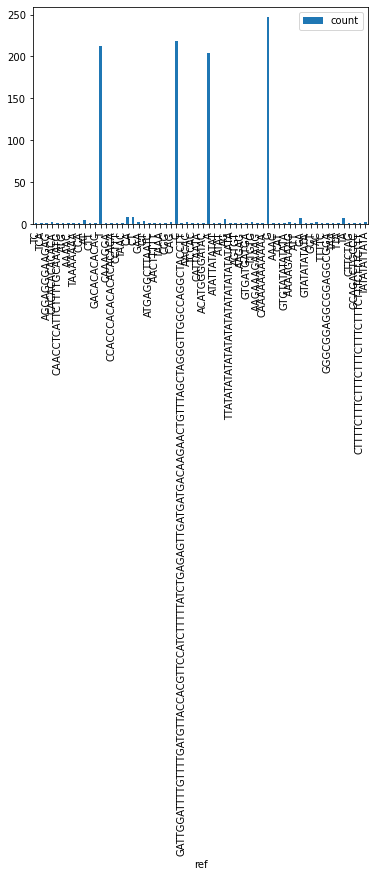

In [81]:
import matplotlib.pyplot as plt
anno2.groupby("ref").count().toPandas().plot.bar(x='ref')

<AxesSubplot:ylabel='count'>

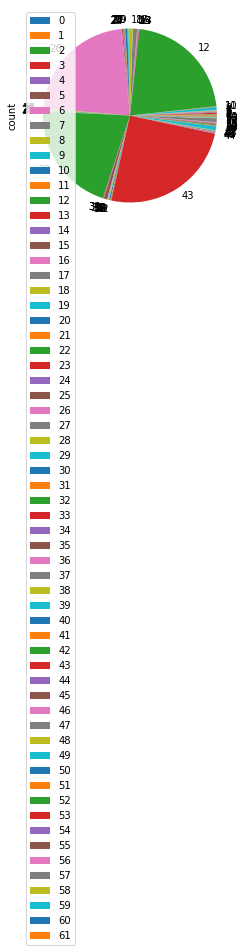

In [83]:
anno2.groupby("ref").count().toPandas().plot.pie(y='count')

## <span style='background:yellow'> ZADANIE  </span>
Przerób powyższe dwa rysunki, tak żeby pokazywały rozkład referencji tylko dla SNV (bez indeli).


<AxesSubplot:ylabel='count'>

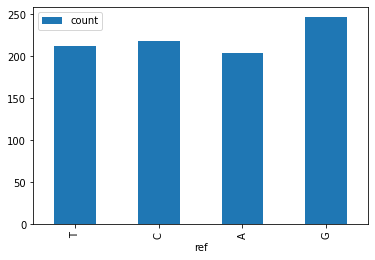

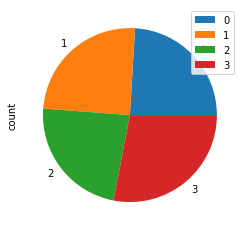

In [88]:
anno2.filter("ref in ('A','C', 'T', 'G')").groupby("ref").count().toPandas().plot.bar(x='ref')
anno2.filter("ref in ('A','C', 'T', 'G')").groupby("ref").count().toPandas().plot.pie(y='count')

## <span style='background:yellow'> ZADANIE  </span>
Przygotuj pie chart dla kolumny Consequences. Uwzględnij jedną konsekwencję dla każdego wariantu.

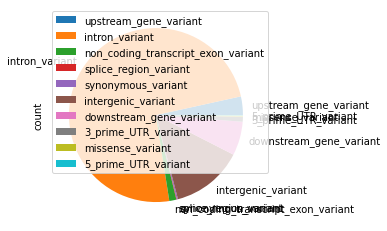

In [113]:
from pyspark.sql.functions import *

df = anno2.withColumn("Consequence_sel", anno2.Consequence.getItem(0)).groupBy("Consequence_sel").count().toPandas()
df.plot.pie(y="count", labels=df["Consequence_sel"])
plt.legend(loc="upper left")
plt.show()

In [10]:
spark.stop()